# Full detector response

The detector response provides us with the the following information:
- The effective area at given energy for given direction. This allows us to convert from counts to physical quantities like flux
- The expected distribution of measured energy and other reconstructed quantities. This allows us to account for all sorts of detector effects when we do our analysis.

This tutorial will show you how to handle detector response and extrat useful information from it.

## Dependencies

In [1]:
%%capture
import numpy as np
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib.pyplot as ply

from mhealpy import HealpixMap, HealpixBase
import pandas as pd
from pathlib import Path

from scoords import Attitude, SpacecraftFrame
from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy import test_data
from cosipy.util import fetch_wasabi_file
from histpy import Histogram
import gc

from threeML import Model, Powerlaw

from cosipy.response import FullDetectorResponse

## File downloads

You can skip this step if you already downloaded the files. Make sure that paths point to the right files

In [2]:
data_dir = Path("") # Current directory by default. Modify if you can want a different path

ori_path = data_dir/"20280301_3_month.ori"
response_path = data_dir/"SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5"

# download orientation file ~684.38 MB
if not ori_path.exists():
    fetch_wasabi_file("COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori", ori_path)

# download response file ~839.62 MB
if not response_path.exists():
    
    response_path_zip = str(response_path) + '.zip'
    fetch_wasabi_file("COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip",response_path_zip)
    
    # unzip the response file
    shutil.unpack_archive(response_path_zip)
    
    # delete the zipped response to save space
    os.remove(response_path_zip)

## Opening a full detector response

The response of the instrument in encoded in a series of matrices cointained in a file. you can open the file like this:

In [3]:
response = FullDetectorResponse.open(response_path)

print(response.filename)

response.close()

SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5


Or if you don't want to worry about closing the file, use a context manager statement:

In [4]:
with FullDetectorResponse.open(response_path) as response:

    print(repr(response))

FILENAME: '/Users/imartin5/software/cosipy/docs/tutorials/response/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 768
    NSIDE: 8
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 36
    EDGES: [0.0 deg, 5.0 deg, 10.0 deg, 15.0 deg, 20.0 deg, 25.0 deg, 30.

Although opening a detector response does not load the matrices, it loads all the header information above. This allows us to pass it around for various analysis at a very low cost.

## Detector response matrix

The full --i.e. all-sky-- detector response is encoded in a HEALPix grid. For each pixel there is a multidimensional matrix describing the response of the instrument for that particular direction in the spacefraft coordinates. For this response has the following grid:

In [5]:
with FullDetectorResponse.open(response_path) as response:
    
    print(f"NSIDE = {response.nside}")
    print(f"SCHEME = {response.scheme}")
    print(f"NPIX = {response.npix}")
    print(f"Pixel size = {np.sqrt(response.pixarea()).to(u.deg):.2f}")

NSIDE = 8
SCHEME = RING
NPIX = 768
Pixel size = 7.33 deg


To retrieve the detector response matrix for a given pixel simply use the `[]` operator

In [6]:
with FullDetectorResponse.open(response_path) as response:
    
    print(f"Pixel 0 centered at {response.pix2skycoord(0)}")
    drm = response[0]

Pixel 0 centered at <SkyCoord (SpacecraftFrame: attitude=None, obstime=None, location=None): (lon, lat) in deg
    (45., 84.14973294)>


Or better, get the interpolated matrix for a given direction. In this case, for the on-axis response:

In [7]:
with FullDetectorResponse.open(response_path) as response:
    
    drm = response.get_interp_response(SkyCoord(lon = 0*u.deg, lat = 0*u.deg, frame = SpacecraftFrame()))

The matrix has multiple dimensions, including real photon initial energy, the measured energy, the Compton data space, and possibly other:

In [8]:
drm.axes.labels

array(['Ei', 'Em', 'Phi', 'PsiChi'], dtype='<U6')

However, one of the most common operation is to get the effective area and the energy dispersion matrix. This is encoded in a reduced detector response, which is the projection of the full matrix into the initial and measured energy axes:

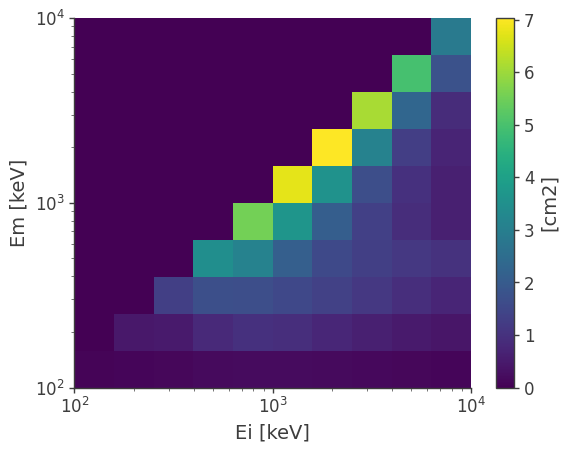

In [9]:
drm.get_spectral_response().plot();

You can further project it into the initial energy to get the effective area:

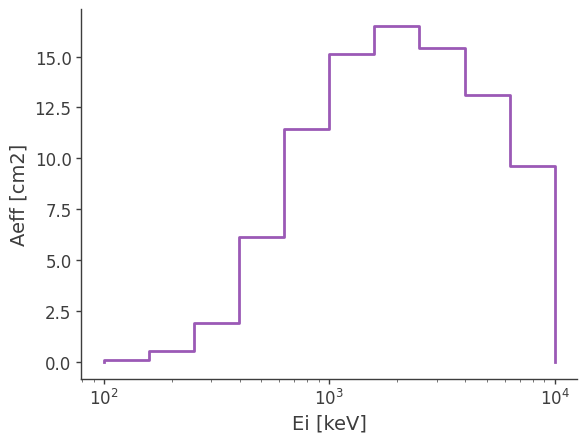

In [10]:
ax,plot = drm.get_effective_area().plot();

ax.set_ylabel(f'Aeff [{drm.unit}]');

Get the interpolated effective area

In [11]:
drm.get_effective_area(511*u.keV)

<Quantity 6.34064809 cm2>

Or the energy dispersion matrix

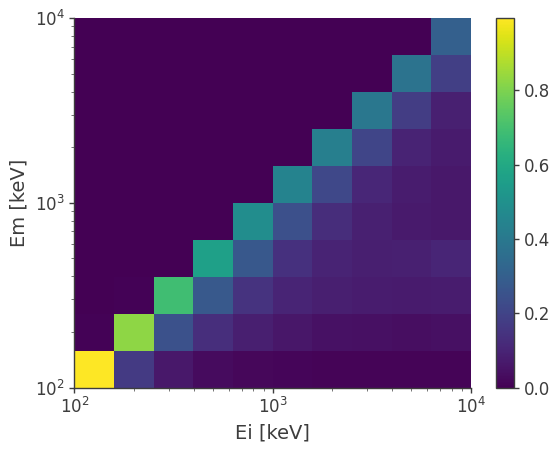

In [12]:
drm.get_dispersion_matrix().plot();

## Point source response and expected counts

Once we have the response, the next step is usually to get the expected counts for a specific source. However, it is not trivial for the case of a spacecraft because the response we have here is the detector response. This response records the detector effects to given points viewed from the reference frame attached to the spacecraft (SC).

A source with a fixed position on the sky is moving from the perspective of the spacecraft (detector). Therefore, we need to convert the coordinate of a source to the reference frame, which results in a moving point viewed the spacecraft. By convolving the trajectory of the source in the spacecraft frame with the detector response, we will get the so-called point source response.

See the <a href="relative/link.html">spacecraft file tutorial</a> for a discussion of the SC attitude history, transformations to/from galactic coordinates, and the dwell time map.

In [13]:
# read the full oritation
ori = SpacecraftFile.parse_from_file(ori_path)

# define the target coordinates (Crab)
target_coord = SkyCoord(184.5551, -05.7877, unit = "deg", frame = "galactic")

# get the target movement in the reference frame attached to the detector
target_in_sc_frame = ori.get_target_in_sc_frame(target_name = "Crab", target_coord = target_coord)

# Get the dwell time map
dwell_time_map = ori.get_dwell_map(response = response_path, src_path = target_in_sc_frame)

Now converting to the Spacecraft frame...
Conversion completed!


We can now convolve the exposure map with the full detector response, and get a PointSourceResponse

In [14]:
with FullDetectorResponse.open(response_path) as response:
    psr = response.get_point_source_response(exposure_map = dwell_time_map, coord = target_coord)

Note that a PointSourceResponse only depends on the path of the source, not on the spectrum of the source. It has units of area*time

In [15]:
psr.unit

Unit("cm2 s")

Finally, we convolve a spectrum to get the spected excess for each *measured* energy bin:

In [16]:
index = -2.2
K = 10**-3 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV

spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit
    
expectation = psr.get_expectation(spectrum)

Text(0, 0.5, 'Expected counts')

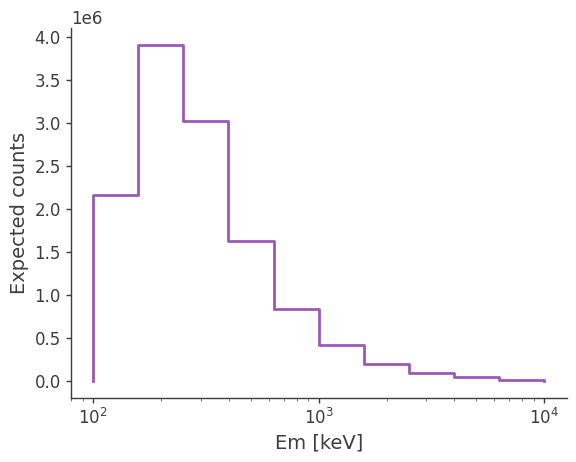

In [17]:
ax, plot = expectation.project('Em').plot()

ax.set_ylabel('Expected counts')

Try changing the spectrum and se how the expected excess changes.

Text(0, 0.5, 'Expected counts')

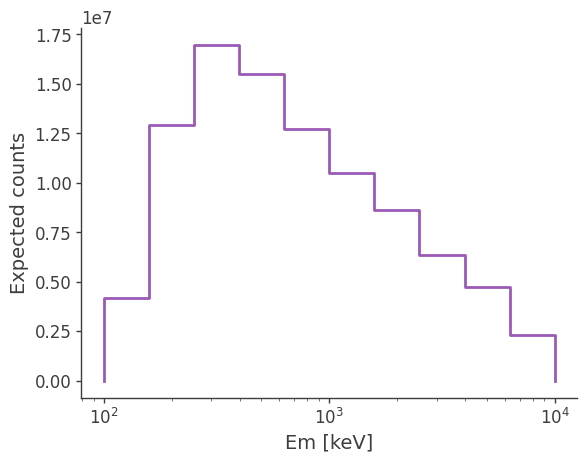

In [18]:
spectrum.index.value = -1

expectation = psr.get_expectation(spectrum)

ax, plot = expectation.project('Em').plot()

ax.set_ylabel('Expected counts')

## Point source response in inertial coordinates

In the previous example we obtained the response for a point source as seen in the reference frame attached to the spacecraft (SC) frame. As the spacecraft rotates, a fixed source in the sky is seen by the detector from multiple direction, so binnind the data on the spacecraft coordinate, without binning it simultenously in time, can wash out the signal. As shown in this section, we can instead rotate the response and convolve it the attitude history of the spacecraft, resulting in a point source response with a Compton data space binned in inertial coordinates.

We use a scatt map, which tracks the amount of time the spacecraft spent in a given orientation. See <a href="relative/link.html">spacecraft file tutorial</a> for more details.

In [19]:
scatt_map = ori.get_scatt_map(nside = 16, coordsys = 'galactic')


WARNING ErfaWarning: ERFA function "utctai" yielded 7979956 of "dubious year (Note 3)"



Now we can let cosipy perform the convolution with the scatt map and get the point source response:

In [20]:
%%time

from astropy.coordinates import SkyCoord

coord = SkyCoord.from_name('Crab').galactic

with FullDetectorResponse.open(response_path) as response:
    psr = response.get_point_source_response(coord = coord, scatt_map = scatt_map)

CPU times: user 46 s, sys: 5.45 s, total: 51.4 s
Wall time: 54.3 s


This is how a slice of the response looks like in galactic coordinates:

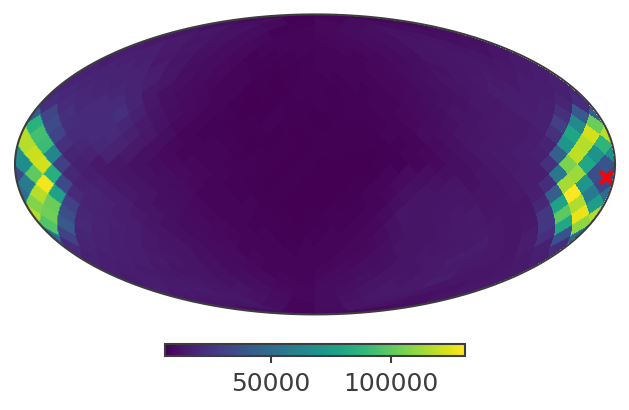

In [21]:
psichi_slice = psr.slice[{'Ei':4, 'Phi':4}].project('PsiChi')

ax,plot = psichi_slice.plot(ax_kw = {'coord':'G'})

ax.scatter([coord.l.deg], [coord.b.deg], transform = ax.get_transform('world'), marker = 'x', color = 'red')

And here in ICRC (RA/Dec), the default coordinates for plot()

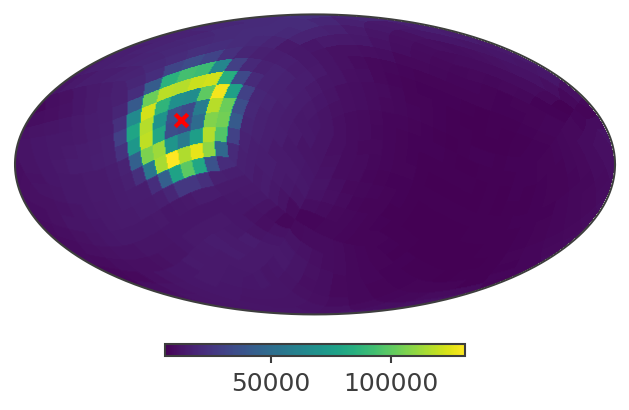

In [22]:
ax,plot = psichi_slice.plot()

ax.scatter([coord.icrs.ra.deg], [coord.icrs.dec.deg], transform = ax.get_transform('world'), marker = 'x', color = 'red')

You can also used it the same way as a point source response obtained from a exposure map. e.g.

Text(0, 0.5, 'Expected counts')

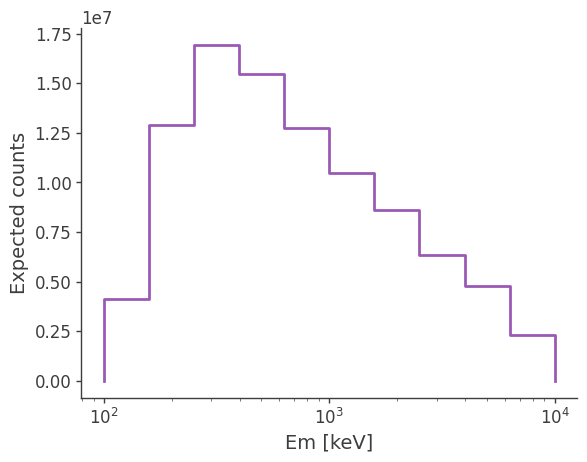

In [23]:
expectation = psr.get_expectation(spectrum)

ax, plot = expectation.project('Em').plot()

ax.set_ylabel('Expected counts')

Lastly, you can obtain the response for multiple coordinstes at once. This can be useful for e.g. imaging

In [24]:
%%time
gal_grid = HealpixBase(nside = 16, coordsys = 'galactic')

gal_coords = gal_grid.pix2skycoord(range(gal_grid.npix))

with FullDetectorResponse.open(response_path) as response:
    response.get_point_source_response(coord = gal_coords[10:12], scatt_map = scatt_map)

CPU times: user 55.8 s, sys: 10 s, total: 1min 5s
Wall time: 1min 6s


You can see that the time is takes to perform this conversion is not lineas with the number of coordinates, so it's better to do it in parallel if you have enough memory.

## XSPEC support

You can also convert the point source response to XSPEC readable files (arf, rmf and pha) if you want to do spetral fitting or simulation in XSPEC. See the `SpacecraftFile` class functions `get_arf()`, `get_rmf()` and `get_pha()`, respectively.

<div class="alert alert-block alert-info">
<b>Note:</b> This functionality will be moved to the DetectorResponse class in the near future. </div>

In [25]:
ori.get_psr_rsp(response = response_path);

Getting the effective area ...
Getting the energy redistribution matrix ...


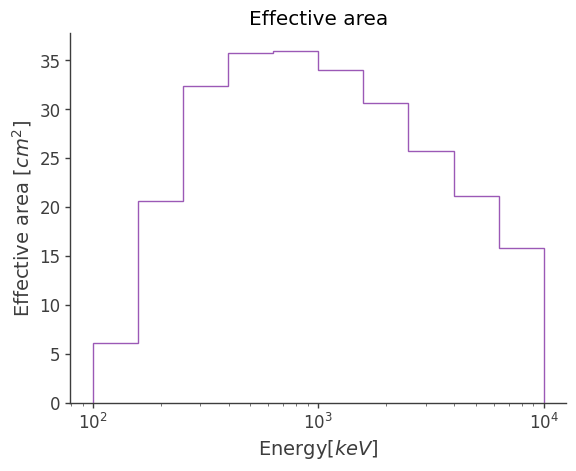

In [26]:
ori.get_arf()
ori.plot_arf()


WARNING VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



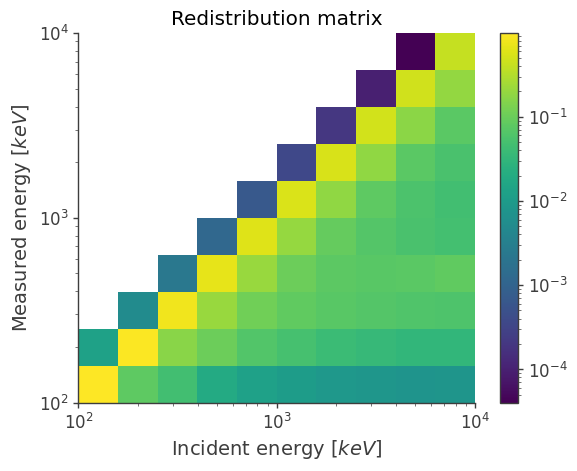

In [27]:
ori.get_rmf()
ori.plot_rmf()